<h3>Analysis for Youtuber

The workflow goes through six stages.

0. Question and problem definition
1. Get the Youtuber imformation by API
2. Wrangle, prepare, cleanse the data
3. Analyze, identify patterns, and explore the data
4. Visualize, report, and present the problem solving steps and final solution.
5. Visualization by Tableau

<h3>0. Question and problem definition

I want to gather information about my favorite YouTuber to understand what makes them famous. \
To do this, I have decided to retrieve data using the YouTube API. I then store this data in a SQL database and visualize it in Tableau. \
Before visalizing to Tableau, I did EDA in this workbook.\
For this analysis, I have chosen "Tokai On air," a Japanese YouTuber with 6.88 million subscribers as an example.

1. Which parameter is related to the number of views?
2. Is this YouTuber still experiencing growth?
3. How to increase the number of views?

<h3>1. Get the Youtuber imformation by API

Using the requests, I got access to the necesarry information from Youtube API.

In [239]:
import requests
import pandas as pd
import numpy as np
import time
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns

In [246]:
API_KEY = "XXXXX"
CHANNEL_ID = 'UCutJqz56653xV2wwSvut_hQ'#Tokai on air ID

Defined to defs to get necesary informartion. 

In [114]:
#Getting the videos detail informations.
def get_stat(video_id):
    url_stat = "https://www.googleapis.com/youtube/v3/videos?id=" + video_id + "&part=statistics&key=" + API_KEY
    response_stat = requests.get(url_stat).json()

    try:
        view_count = response_stat['items'][0]['statistics']['viewCount']
    except KeyError:
        view_count = None

    try:
        like_count = response_stat['items'][0]['statistics']['likeCount']
    except KeyError:
        like_count = None

    try:
        comment_count = response_stat['items'][0]['statistics']['commentCount']
    except KeyError:
        comment_count = None

    return view_count, like_count, comment_count


In [115]:
def get_data():
    df = pd.DataFrame(columns=['video_id', 'upload_date', 'video_title', 'description', 'view_count', 'likeCount', 'commentCount'])
    page_token = None

    while True:
        url = "https://www.googleapis.com/youtube/v3/search?key=" + API_KEY + "&channelId=" + CHANNEL_ID + "&part=snippet,id&order=date&maxResults=50"

        if page_token:
            url += "&pageToken=" + page_token

        response = requests.get(url).json()

        for video in response['items']:
            if video['id']['kind'] == 'youtube#video':
                video_id = video['id']['videoId']
                video_title = video['snippet']['title']
                upload_date = video['snippet']['publishTime']
                upload_date = str(upload_date).split('T')[0]
                description = video['snippet']['description']

                view_count, like_count, comment_count = get_stat(video_id)

                df = df.append({'video_id': video_id, 'upload_date': upload_date, 'video_title': video_title, 'description': description, 'view_count': view_count, 'likeCount': like_count, 'commentCount': comment_count}, ignore_index=True)

        if 'nextPageToken' not in response:
            break

        page_token = response['nextPageToken']
        time.sleep(1)

    return df


In [ ]:
df = get_data()

<h3>2. Wrangle, prepare, cleanse the data

Eliminate blan data then, changed the data type and change to ascending.

In [210]:
df1 = df.dropna()
df1['view_count'] = df1['view_count'].astype('int')
df1['likeCount'] = df1['likeCount'].astype('int')
df1['commentCount'] = df1['commentCount'].astype('int')
df1['upload_date'] = pd.to_datetime(df1['upload_date'])
df1['year_month'] = df1['upload_date'].dt.strftime('%Y-%m')
df1['Channel'] = 'Tokai on air'
df3 = df1.sort_values('year_month', ascending=True)
df3['quarter'] = df3['upload_date'].dt.to_period('Q')
df1['quarter'] = df3['upload_date'].dt.to_period('Q')

In [ ]:
df1.head()

,video_id,upload_date,video_title,description,view_count,likeCount,commentCount,year_month,Channel
0,ZaCdIB760_I,2023-05-20,【ヤケクソ長時間動画】単三電池で遊び続けて電池切れした奴の負け！！！！！前編【電タメ革命】,(編集：てつや) どうも、東海オンエアです。 ぜひチャンネル登録お願いします！ サブチャンネ...,716156,13162,873,2023-05,Tokai on air
1,M30ioXNpxIA,2023-05-19,【横暴俳優】くじ引きで引いた４シーン、無理やり使ってドラマ作ってこい！,編集 しば どうも、東海オンエアです。 ぜひチャンネル登録お願いします！ サブチャンネル【東...,890331,18893,760,2023-05,Tokai on air
2,Grs5sJ6DlnI,2023-05-17,【激アツ決着】相手を満腹にしろ！ご飯食べ食べUNO！！！,(編集：てつや) 【食えなきゃ負け】相手を満腹にしろ！ご飯食べ食べポーカー！！！前編 ...,2325350,47417,2687,2023-05,Tokai on air
3,pweUjpotre0,2023-05-16,マジのお店に東海オンエアが考えた｢商品がたくさん売れる棚｣を置いてもらおう！,この動画はマツキヨココカラ＆カンパニーとのタイアップです キャンペーン名：開け夏の扉！マツキ...,1593120,23670,1152,2023-05,Tokai on air
4,bxhQ98TrCQQ,2023-05-15,50回目の人は調味料一気喰い‼️,,3063823,73054,498,2023-05,Tokai on air


Columns explanation:\

video_id: Unique IDs assigned by YouTube.\
upload_date: The date when the video was uploaded.\
video_title: The title of the video.\
description: The description of the video.\
view_count: The number of views the video has received.\
likeCount: The number of likes the video has received.\
commentCount: The number of comments posted on the video.

<h3>3. Analyze, identify patterns, and explore the data

Here you can see Top 10 videos from this Youtuber

In [193]:
df1.sort_values('view_count', ascending=False).iloc[0:10,[1,2,4]]

,upload_date,video_title,view_count
418,2016-09-13,新競技「1500m牛丼」で世界新記録達成！！,22322825
345,2020-03-13,【遅刻撲滅運動】撮影日の朝に時間を一切見ずに行動したら逆に遅刻しないんじゃね？？？,21296648
407,2018-01-25,手作りろ過装置で泥水を美味しく召し上がってやるぜ！,20698774
404,2018-04-05,【カオス再び】第一回！ 工藤新一選手権！！！,20211973
396,2018-08-18,【ピタリ賞100万円】1500kcalちょうどを目指して飯を食え！,18827169
56,2022-07-04,母音が「i」の言葉だけでロウソクの火を消せるか⁉︎,18749204
401,2018-05-10,【まさかの水泳対決】２泊３日！寝たら&quot;即帰宅&quot;の旅！Part２,18538573
348,2020-03-05,【ペペロン】猛練習したてつしばの料理VS練習なしのりょうの料理,18303127
392,2018-10-05,【暴飲暴食】１週間でとにかく太った方が勝ち対決！！！,17562841
338,2020-04-16,【超本格的】大岩亭の伝説のラーメンを完全再現してみせます,17182021


Looks like this channel is more popular before 2020. 

To see which parametor has relationship with number of views, I checked the correlation "Liked counts" and "Number of comments"

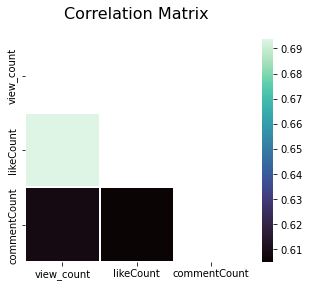

In [241]:
corr = df1.iloc[0:,[4,5,6,]].corr()
# This correlation matrix is huge, so we take only a triangular one.
triu_mask = np.triu(corr)

plt.figure(figsize=(5, 5))
sns.heatmap(
    corr,
    square=True,
    linewidths=2,
    annot=False,
    mask=triu_mask,  # Lower triangle.
    cbar_kws={"shrink": 0.82},
    cmap="mako",
)
plt.title("Correlation Matrix", fontsize=16, pad=20)
plt.show()

In [242]:
corr

,view_count,likeCount,commentCount
view_count,1.000000,0.693792,0.608554
likeCount,0.693792,1.000000,0.605116
commentCount,0.608554,0.605116,1.000000


This shows each parsametor has positive correlations.\
Next, we can see by graph for this correlation.

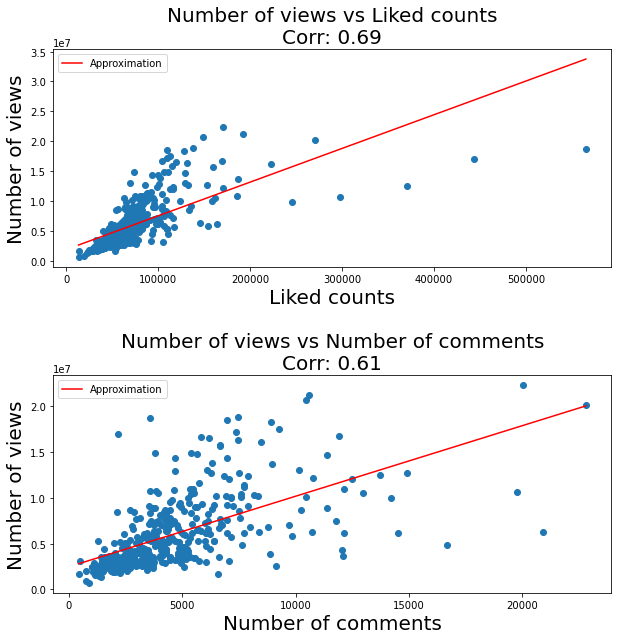

In [245]:
import numpy as np

x1 = df1['likeCount']
y1 = df1['view_count']
coefficients1 = np.polyfit(x1, y1, 1)
poly1 = np.poly1d(coefficients1)
x1_fit = np.linspace(x1.min(), x1.max(), 100)
y1_fit = poly1(x1_fit)

x2 = df1['commentCount']
y2 = df1['view_count']
coefficients2 = np.polyfit(x2, y2, 1)
poly2 = np.poly1d(coefficients2)
x2_fit = np.linspace(x2.min(), x2.max(), 100)
y2_fit = poly2(x2_fit)

corr1 = np.corrcoef(x1, y1)[0, 1]
corr2 = np.corrcoef(x2, y2)[0, 1]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
fig.subplots_adjust(hspace=0.5)

ax1.scatter(x1, y1)
ax1.plot(x1_fit, y1_fit, color='red', label='Approximation')
ax1.set_xlabel('Liked counts', fontsize=20)
ax1.set_ylabel('Number of views', fontsize=20)
ax1.set_title('Number of views vs Liked counts\nCorr: {:.2f}'.format(corr1), fontsize=20)
ax1.legend()

ax2.scatter(x2, y2)
ax2.plot(x2_fit, y2_fit, color='red', label='Approximation')
ax2.set_xlabel('Number of comments', fontsize=20)
ax2.set_ylabel('Number of views', fontsize=20)
ax2.set_title('Number of views vs Number of comments\nCorr: {:.2f}'.format(corr2), fontsize=20)
ax2.legend()

plt.show()


Both number of comments and liked counts have positive correlations with number of counts.

In [216]:
df2 = df1.iloc[0:, [4,5,6,7]]
sum_df = df2.groupby('year_month').sum()
df2 = df1.iloc[0:, [4,5,6,7]]
Average_df = df2.groupby('year_month').mean()

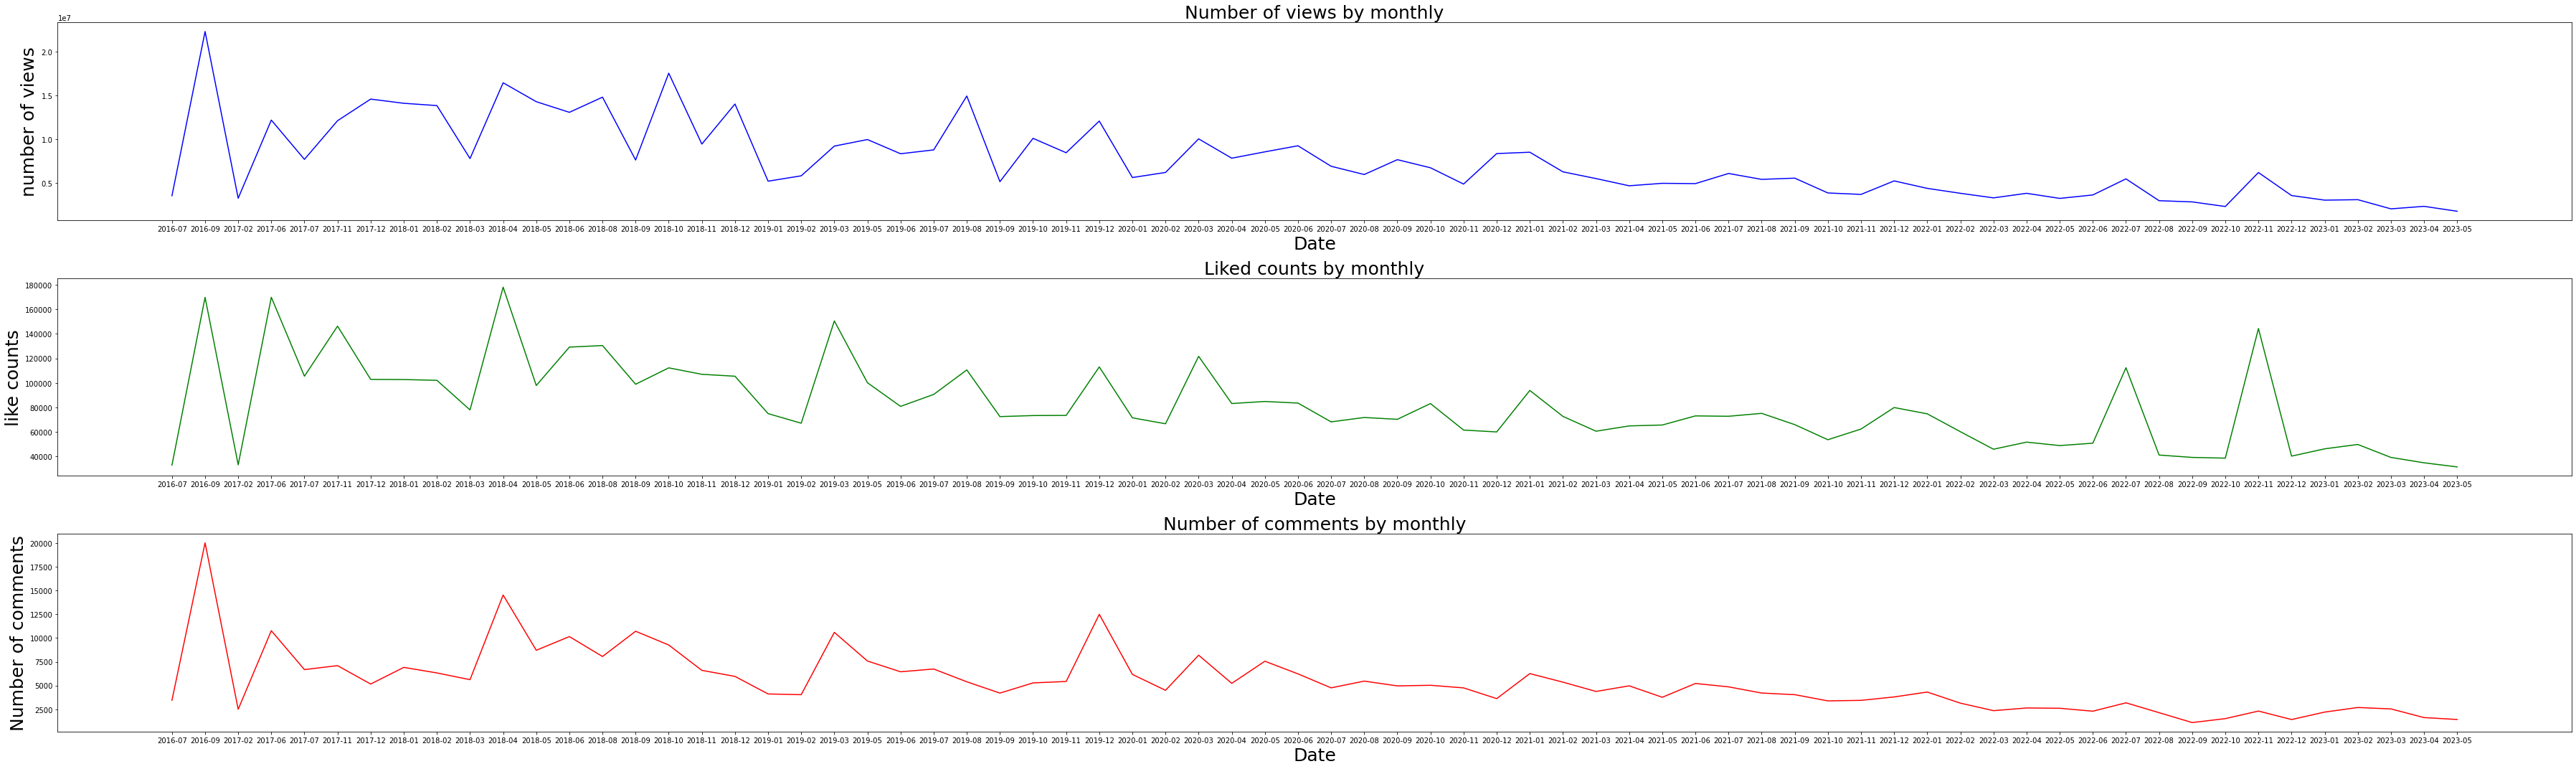

In [217]:
fig, (ax1, ax2,ax3) = plt.subplots(3, 1, figsize=(50, 15))
fig.subplots_adjust(hspace=0.5)
ax1.plot(Average_df.index, Average_df['view_count'] ,color='blue')
ax1.set_xlabel('Date',fontsize=25)
ax1.set_ylabel('number of views',fontsize=25)
ax1.set_title('Number of views by monthly',fontsize=25)

ax2.plot(Average_df.index, Average_df['likeCount'] ,color='green')
ax2.set_xlabel('Date',fontsize=25)
ax2.set_ylabel('like counts',fontsize=25)
ax2.set_title('Liked counts by monthly',fontsize=25)

ax3.plot(Average_df.index, Average_df['commentCount'] ,color='red')
ax3.set_xlabel('Date',fontsize=25)
ax3.set_ylabel('Number of comments',fontsize=25)
ax3.set_title('Number of comments by monthly',fontsize=25)
plt.tight_layout()

plt.show()


Viwed counts are strongly related to the liked counts anf commented counts.

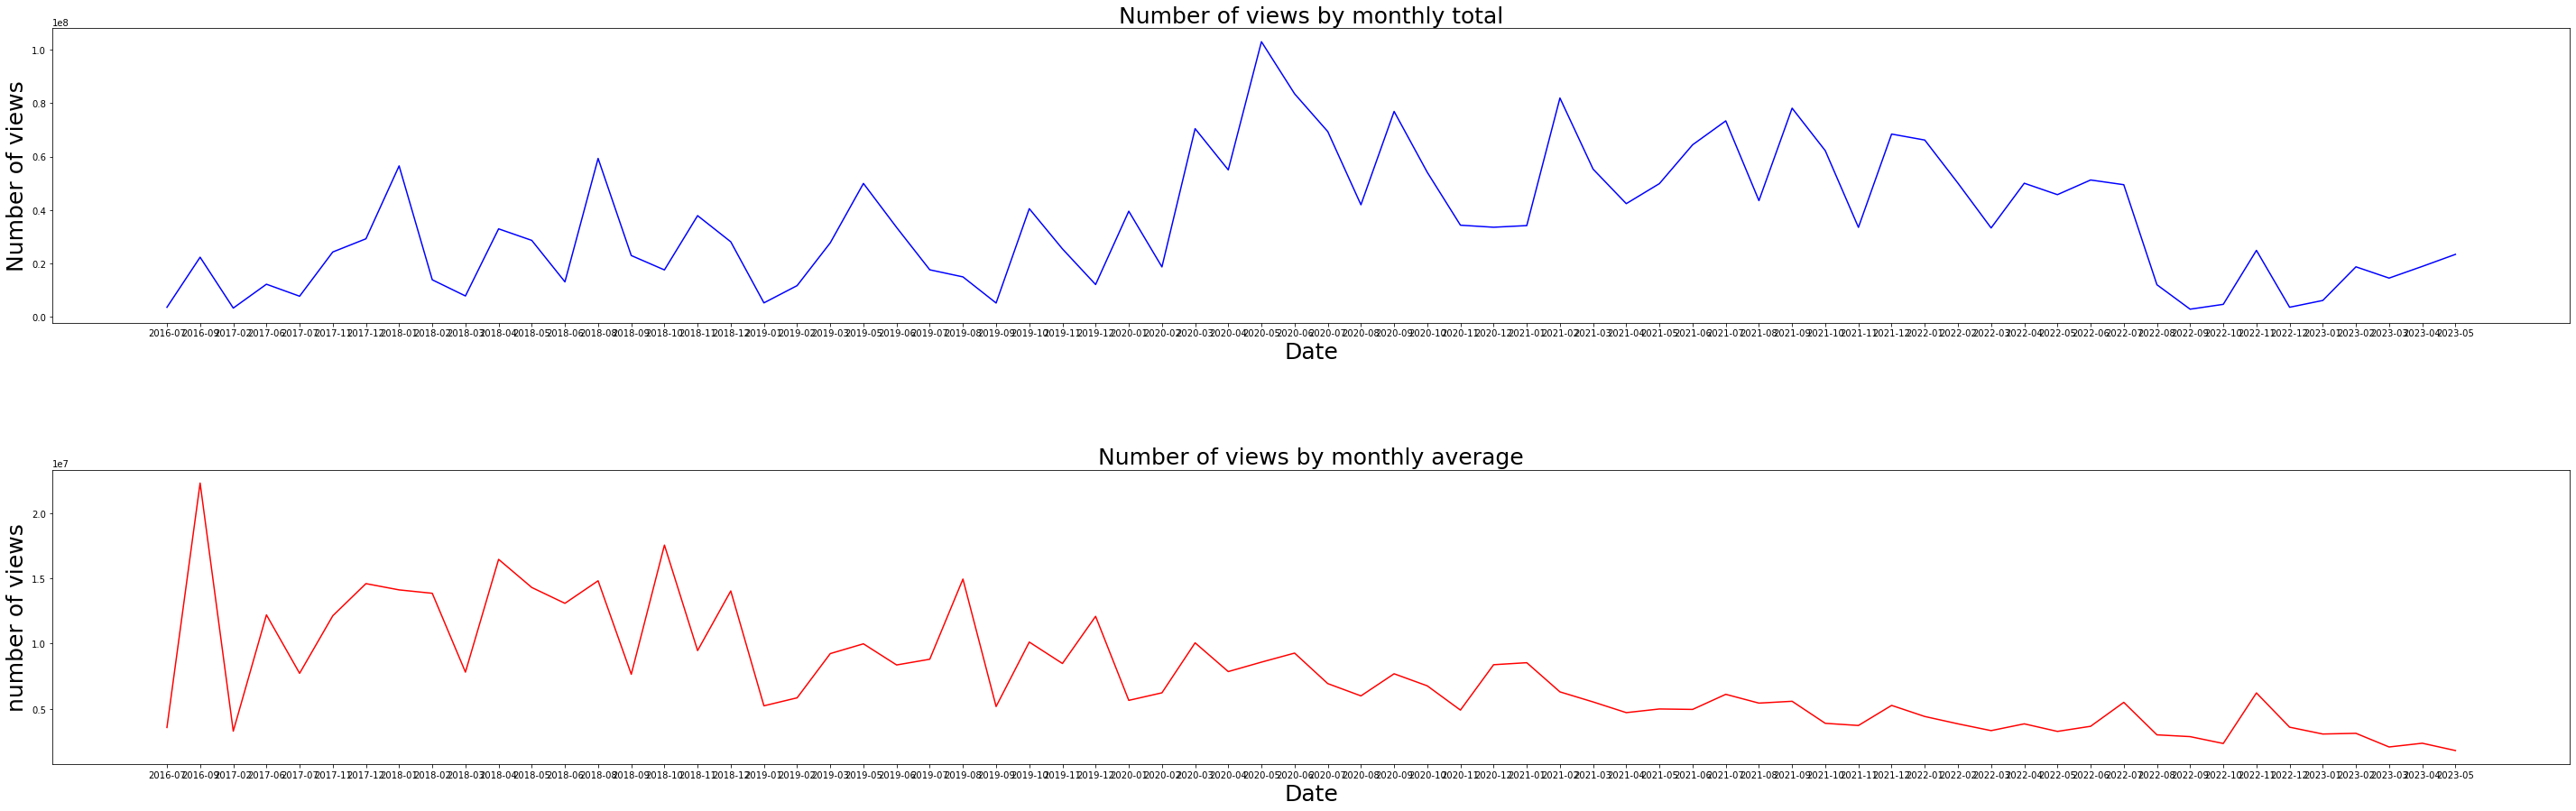

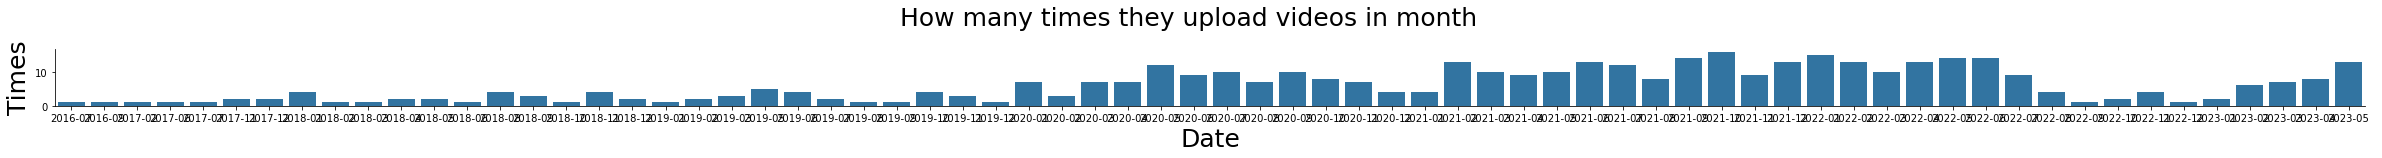

In [205]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(50, 15))
fig.subplots_adjust(hspace=0.5)
ax1.plot(sum_df.index, sum_df['view_count'] ,color='blue')
ax1.set_xlabel('Date',fontsize=25)
ax1.set_ylabel('Number of views',fontsize=25)
ax1.set_title('Number of views by monthly total',fontsize=25)

ax2.plot(Average_df.index, Average_df['view_count'] ,color='red')
ax2.set_xlabel('Date',fontsize=25)
ax2.set_ylabel('number of views',fontsize=25)
ax2.set_title('Number of views by monthly average',fontsize=25)

df3 = df1.sort_values('year_month', ascending=True)
grid = sns.FacetGrid(df3,  height=2.2, aspect=15)
grid.map(sns.countplot, 'year_month')
grid.fig.subplots_adjust(top=0.9)
grid.fig.suptitle('How many times they upload videos in month', fontsize=25)
grid.set_axis_labels('Date', 'Times', fontsize=25)
grid.add_legend()

plt.tight_layout()

plt.show()


It appears that starting from 2020, the YouTuber made changes to the number of uploaded videos, which has resulted in a decrease in the number of views for one particular video.\
To more visualize, I made graph by quater.

For now, we can see the each parametor by date.

In [218]:
df2 = df1.iloc[0:, [4,5,6,9]]
sum_df = df2.groupby('quarter').sum()
df2 = df1.iloc[0:, [4,5,6,9]]
Average_df = df2.groupby('quarter').mean()

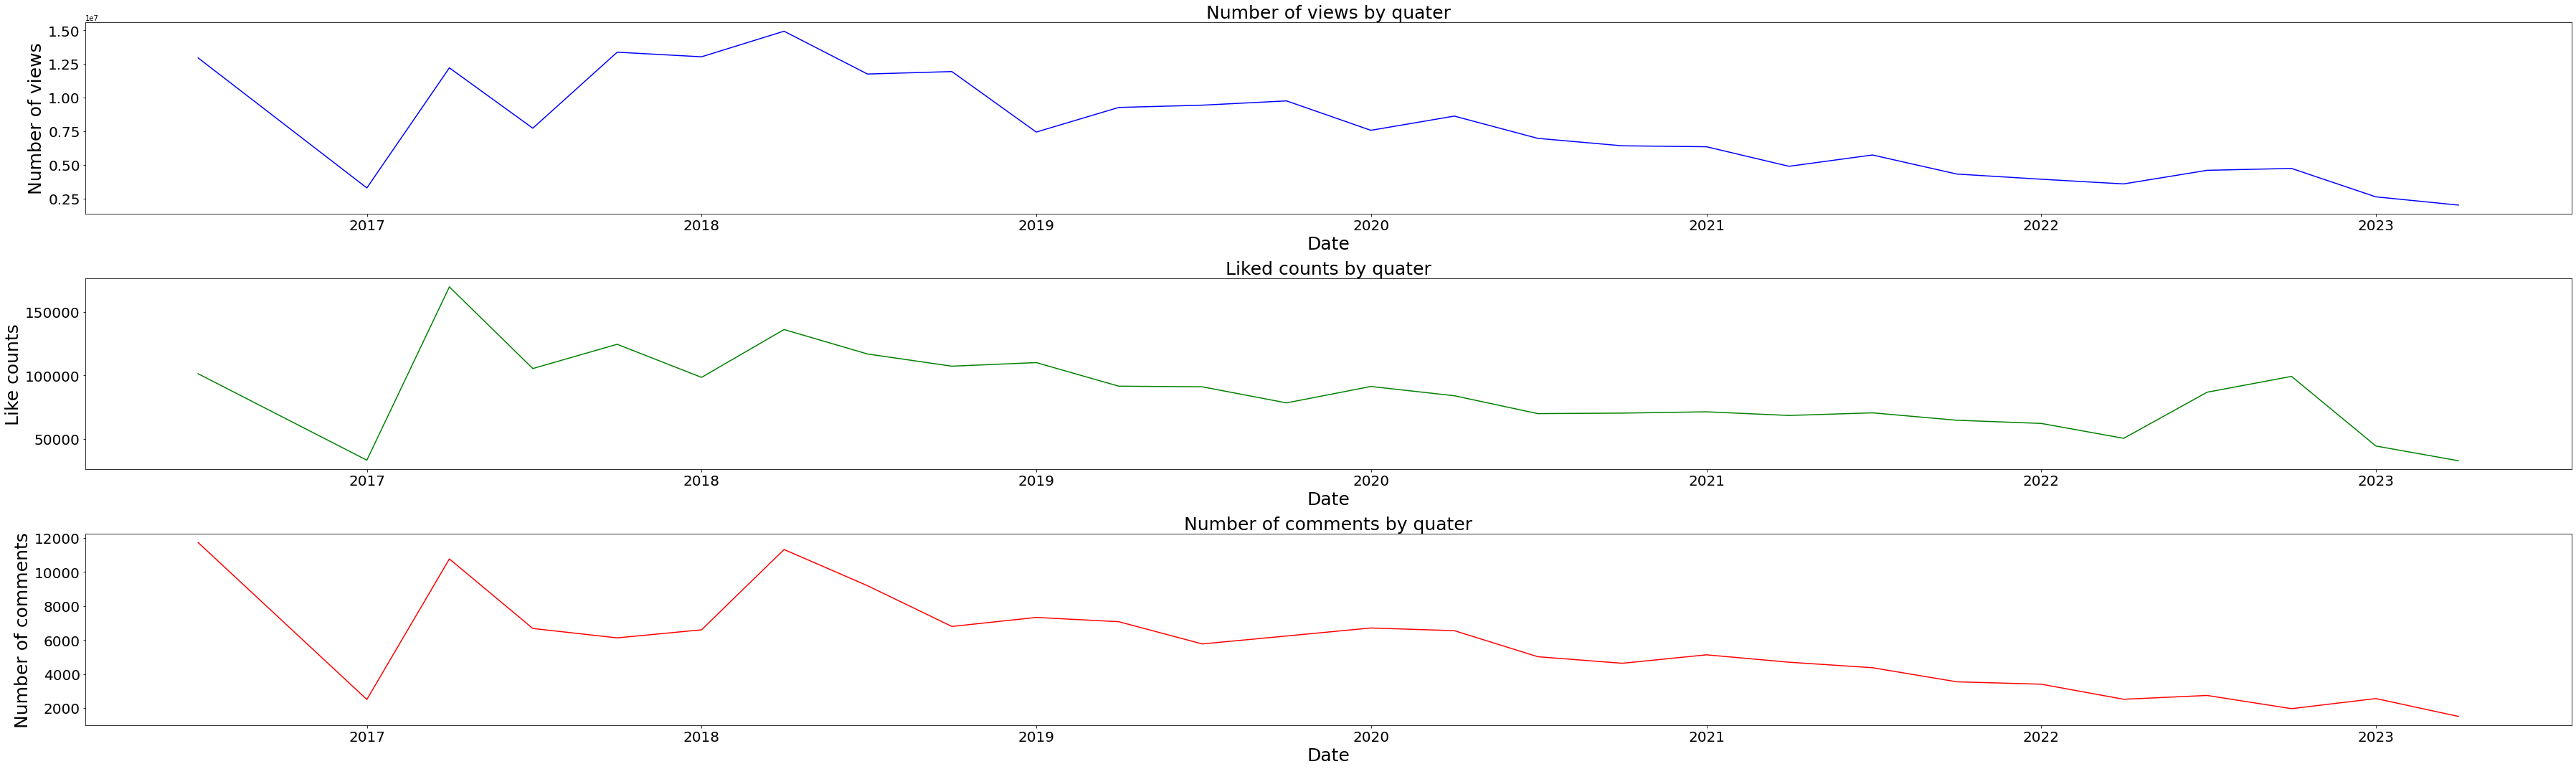

In [233]:
fig, (ax1, ax2,ax3) = plt.subplots(3, 1, figsize=(50, 15))
fig.subplots_adjust(hspace=0.5)
ax1.plot(Average_df.index.to_timestamp(), Average_df['view_count'] ,color='blue')
ax1.set_xlabel('Date',fontsize=25)
ax1.set_ylabel('Number of views',fontsize=25)
ax1.set_title('Number of views by quater',fontsize=25)
ax1.tick_params(axis='both', labelsize=20) 

ax2.plot(Average_df.index.to_timestamp(), Average_df['likeCount'] ,color='green')
ax2.set_xlabel('Date',fontsize=25)
ax2.set_ylabel('Like counts',fontsize=25)
ax2.set_title('Liked counts by quater',fontsize=25)
ax2.tick_params(axis='both', labelsize=20) 

ax3.plot(Average_df.index.to_timestamp(), Average_df['commentCount'] ,color='red')
ax3.set_xlabel('Date',fontsize=25)
ax3.set_ylabel('Number of comments',fontsize=25)
ax3.set_title('Number of comments by quater',fontsize=25)
ax3.tick_params(axis='both', labelsize=20) 
plt.tight_layout()

plt.show()

As you can see, viwed counts are strongly related to the liked counts anf commented counts.

Next, we can see the number of upload videos vs number of views.

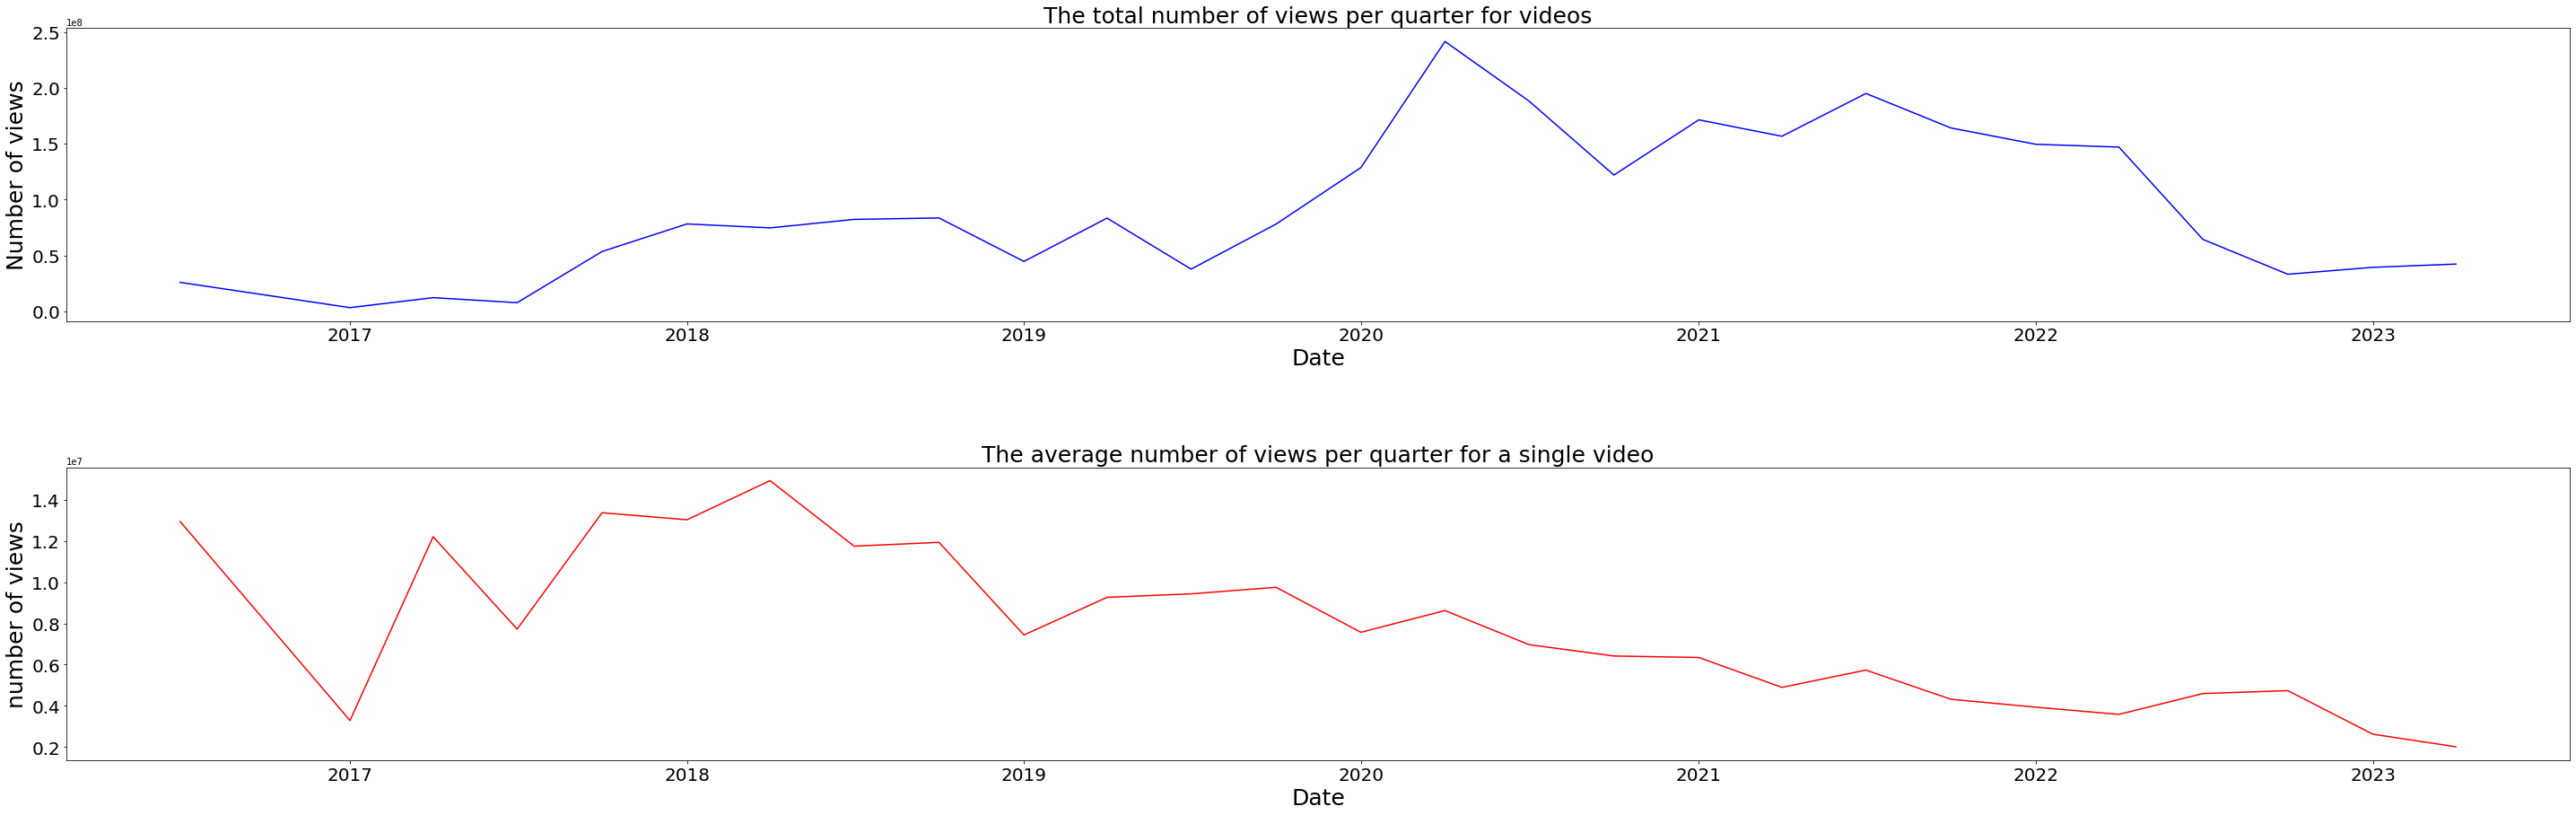

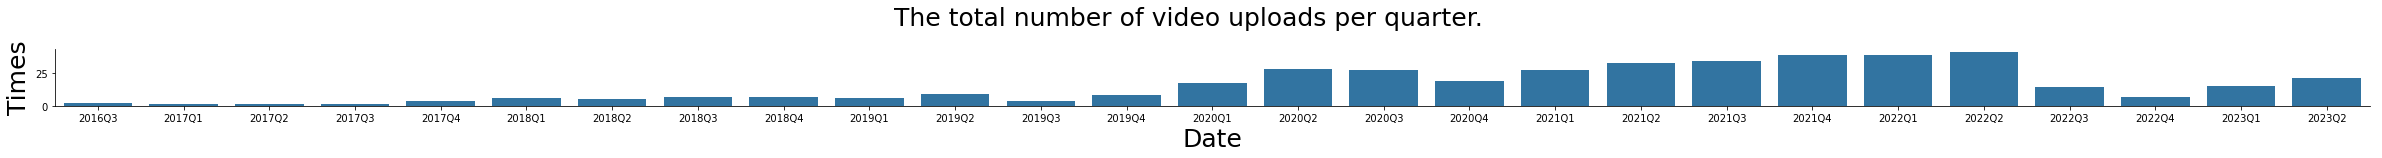

In [231]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(50, 15))
fig.subplots_adjust(hspace=0.5)
ax1.plot(sum_df.index.to_timestamp(), sum_df['view_count'] ,color='blue')
ax1.set_xlabel('Date',fontsize=25)
ax1.set_ylabel('Number of views',fontsize=25)
ax1.set_title('The total number of views per quarter for videos',fontsize=25)
ax1.tick_params(axis='both', labelsize=20) 

ax2.plot(Average_df.index.to_timestamp(), Average_df['view_count'] ,color='red')
ax2.set_xlabel('Date',fontsize=25)
ax2.set_ylabel('number of views',fontsize=25)
ax2.set_title('The average number of views per quarter for a single video',fontsize=25)
ax2.tick_params(axis='both', labelsize=20) 

df3 = df1.sort_values('quarter', ascending=True)
grid = sns.FacetGrid(df3,  height=2.2, aspect=15)
grid.map(sns.countplot, 'quarter')
grid.fig.subplots_adjust(top=0.9)
grid.fig.suptitle('The total number of video uploads per quarter.', fontsize=25)
grid.set_axis_labels('Date', 'Times', fontsize=25)
grid.add_legend()

plt.tight_layout()

plt.show()


The total number of views per quarter for videos are increasing from 2020.\
The average number of views per quarter for a single video are decreasing from 2020.\
The YouTuber made changes to the number of uploaded videos from 2020.

Insight:

It seems that starting from 2020, the YouTuber made adjustments to the frequency of video uploads. As a result, the total number of views per quarter for all videos has increased. However, this increase in views has coincided with a decrease in the average number of views per quarter for an individual video.

This suggests that the YouTuber's strategy of uploading more videos has led to a wider reach and increased overall viewership. However, it also indicates that the individual videos may be receiving less attention or engagement on average.

Overall, these findings highlight the impact of changes in video upload frequency on viewership patterns and suggest the need for further analysis to understand the specific factors influencing these trends.


<h3>4. Visualize, report, and present the problem solving steps and final solution.

What I noticed from datasets.
1. number of comments and liked counts have positive correlations with number of counts.
2. It seems that starting from 2020, the YouTuber made adjustments to the frequency of video uploads. As a result, the total number of views per quarter for all videos has increased. However, this increase in views has coincided with a decrease in the average number of views per quarter for an individual video.

Conclusion:

Which parameter is related to the number of views?
 1. Liked counts and number of comments to the videos
 2. Frquency of the video upload
 3. Affecting the other SNS servios opupancy


Is this YouTuber still experiencing growth?\
I don't think so because from 2020, number of the views for one video is decreasing.

How to increase the number of views?
1. Youtuber sholud intarct with subscriber to increase liked and comments
2. Should not increase the frquency of the video upload

I will take further analysis for other Youtubers. Details is in the Tableau.